In [38]:
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import cv2

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm as SVM
from sklearn.metrics import accuracy_score

# Constants

In [47]:
moods = ["anger","disgust","fear","happiness","sadness","surprise","neutral"]
mood_map = { moods[k]:k for k in range(len(moods)) } # mood : index
mood_map.update({ k:moods[k] for k in range(len(moods)) }) # index : mood

data_path = '../dataset/fer2013/'
model_path = '../models/'

# Preparing the Data

In [49]:
%%time
df = pd.read_csv(data_path + 'vector_coords_norm.csv')
df.head()

,emotion,pixels,Usage,vectors,coords
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,1.0 0.0855595721559356 0.908951992362738 0.053...,0.0 0.05194805194805195 0.0 0.2207792207792207...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,0.9097354562079145 0.03439099146890885 0.84523...,0.0 0.36363636363636365 0.024390243902439025 0...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,0.8700982144280447 0.14542327599970098 0.76867...,0.07228915662650602 0.05 0.03614457831325301 0...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,0.5993885222413324 0.083143088445855 0.5277248...,0.043010752688172046 0.2222222222222222 0.0537...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,0.9739085450273313 0.06621872273103259 0.88574...,0.0 0.25 0.012345679012345678 0.39473684210526...


In [52]:
%%time
num_samples = df.shape[0]

vectors, coords = [], []
for index, row in df.iterrows():
    vectors.append([float(k) for k in row['vectors'].split(' ')])
    coords.append([float(k) for k in row['coords'].split(' ')])
vectors, coords = np.array(vectors), np.array(coords)

Vector = np.dstack((vectors, coords)).reshape(num_samples, -1) # shape=(samples, vectors+coords)
# Label = np.array([mood_map[k] for k in df.mood])
Label = df.emotion
print(Vector.shape, Label.shape)

x_train, x_test, y_train, y_test = train_test_split(Vector, Label, test_size=0.20, random_state=0)

(35887, 272) (35887,)
CPU times: total: 11.5 s
Wall time: 11.6 s


# Training

In [53]:
def train(x_train, y_train):
    params = {'C':[10e-3, 10e-2, 0.1, 1, 10], 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'decision_function_shape':('ovr', 'ovo')}
    svm_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('svm', GridSearchCV(SVM.SVC(max_iter=100000, probability=True, kernel='linear', decision_function_shape='ovr'), params)), ])

    svm_pipe.fit(x_train, y_train)
    print(svm_pipe['svm'].best_params_)
    
    return svm_pipe

In [54]:
def evaluate(svm, data):
    if isinstance(svm, str):
        svm = pickle.load(open(model_path+svm, 'rb'))
    
    x_train, x_test, y_train, y_test = data[0], data[1], data[2], data[3]
    
    # Prediction
    y_train_pred = svm.predict(x_train)
    y_test_pred = svm.predict(x_test)

    # Evaluation
    acc_tr = accuracy_score(y_train, y_train_pred)
    acc_ts = accuracy_score(y_test, y_test_pred)
    print('Train accuracy: %.4f' % acc_tr)
    print('Test accuracy: %.4f' % acc_ts)
    
    return (acc_tr, acc_ts)

In [ ]:
%%time
svm = train(x_train, y_train)

C:\Users\User\venv\emotion_tf\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\User\venv\emotion_tf\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\User\venv\emotion_tf\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\User\venv\emotion_tf\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\User\venv\emotion_tf\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: So

In [ ]:
accs = evaluate(svm, (x_train, x_test, y_train, y_test))

In [27]:
accs = evaluate(svm, (x_train, x_test, y_train, y_test))

Train accuracy: 0.9917
Test accuracy: 0.9558


# Save Model

In [28]:
pickle.dump(svm, open(model_path + 'svm_ck', 'wb'))

# Test Model

In [29]:
test_model = pickle.load(open(model_path + 'svm_ck', 'rb'))

### CK

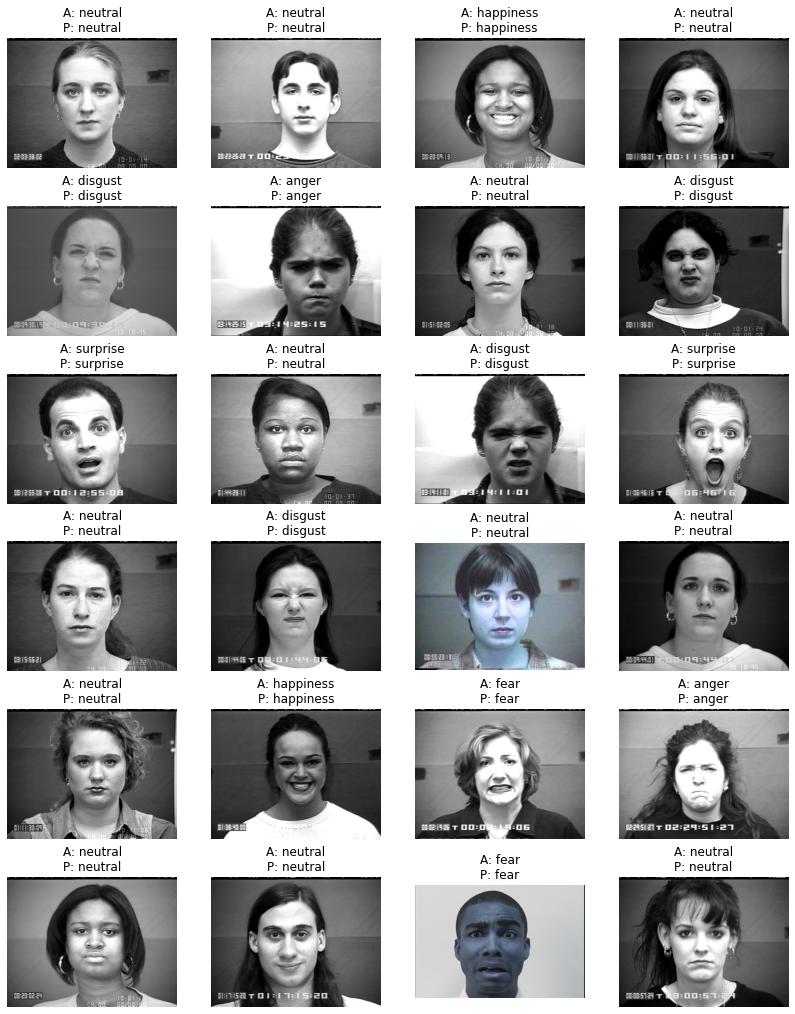

In [46]:
rand = random.sample(range(df.shape[0]), 24)
fig = plt.figure(figsize=(14, 18))

for i in rand:
    filename, mood = df.loc[i,'filename'], df.loc[i,'mood']
    
    # input
    vectors = [float(k) for k in df.loc[i,'vectors'].split(' ')]
    coords = [float(k) for k in df.loc[i,'coords'].split(' ')]
    Vector = np.dstack((vectors, coords)).reshape(1, -1) # shape=(1, 272)

    # prediction
    pred = svm.predict(Vector)[0]
    pred_label = mood_map[pred]

    # plot
    fig.add_subplot(6, 4, rand.index(i)+1)    
    plt.title("A: %s\nP: %s" % (mood, pred_label))
    plt.axis("off")
    img = cv2.imread('%s%s/%s' % (data_path, mood, filename))
    plt.imshow(img)

plt.show()

### FER

In [ ]:
rand = random.sample(range(df.shape[0]), 24)
fig = plt.figure(figsize=(14, 11))

for i in rand:
    pixels = [int(k) for k in df.loc[i,'pixels'].split(' ')]
    emotion = df.loc[i,'emotion']
    
    # input
    vectors = [float(k) for k in df.loc[i,'vectors'].split(' ')]
    coords = [float(k) for k in df.loc[i,'coords'].split(' ')]
    Vector = np.dstack((vectors, coords)).reshape(1, -1) # shape=(1, 272)

    # prediction
    pred = svm.predict(Vector)[0]
    pred_label = mood_map[pred]
    true_label = mood_map[emotion]

    # plot
    fig.add_subplot(4, 6, rand.index(i)+1)    
    plt.title("A: %s\nP: %s" % (true_label, pred_label))
    plt.axis("off")
    plt.imshow(img, cmap="gray")

plt.show()